In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

plt.rcParams["font.family"] = "serif"


In [2]:
def preprocessing(path):
    f=open(path,'r')
    w=open("separated.csv",'w')
    for line in f.readlines():
        if len(line.split())<9:
            continue
        tab_sep_line = "\t".join(line.split())
        w.write(tab_sep_line+"\n")

    w.close()
    dataframe = pd.read_csv(os.getcwd()+"/separated.csv", sep="\t")
    return dataframe   

In [3]:
df = preprocessing("logsample.txt")
df

,Dataset,Queryset,ChgQRatio,Method,Time,AvgMem,PeakMem,#Out,#OutQ
0,STK,STK_Q1,0.0,NAIVE,75.69,3.0,3.0,1235,1235
1,STK,STK_Q1,0.0,SOP,52.59,9.0,9.0,1235,1235
2,STK,STK_Q1,0.0,pMCSKY,59.03,6.0,7.0,1203,1203
3,STK,STK_Q1,0.0,OURS-Q,11.63,5.0,5.0,1235,1235
4,STK,STK_Q1,0.0,OURS-D,4.45,5.0,5.0,1235,1235
5,STK,STK_Q1,0.0,OURS,2.57,5.0,5.0,1235,1235
6,STK,STK_Q1,0.1,NAIVE,75.69,3.0,3.0,1235,1235
7,STK,STK_Q1,0.1,SOP,52.00,9.0,9.0,1235,1235
8,STK,STK_Q1,0.1,pMCSKY,59.52,6.0,7.0,1203,1203
9,STK,STK_Q1,0.1,OURS-Q,10.81,5.0,5.0,1235,1235


In [4]:
dataset = ["STK"] # will be added soon

algo_color = {'NAIVE': 'black',
              'SOP': '#4BACC6',
              'pMCSKY': '#1F497D',
              'OURS-Q': '#F79646',
              'OURS-D': '#9BBB59',
              'OURS': '#C0504D'}

fontsize_Tick=10
fontsize_xLabel=20
fontsize_yLabel=20

algo_line = {'NAIVE': '-',
              'SOP': '-',
              'pMCSKY': '-',
              'OURS-Q': '--',
              'OURS-D': '--',
              'OURS': '-'}

basic_linewidth = 1.5
algo_linewidth = {'NAIVE': basic_linewidth,
                  'SOP': basic_linewidth,
                  'pMCSKY': basic_linewidth,
                  'OURS-Q': basic_linewidth/2,
                  'OURS-D': basic_linewidth/2,
                  'OURS': basic_linewidth}

In [5]:
# for dataname in dataset:
dataname = "STK"
graphdf = df.loc[(df["Dataset"]==dataname) & (df["Queryset"]==(dataname)+"_Q100") & (df['ChgQRatio']>0)].pivot(index="Dataset",columns="Method",values="Time")
graphdf = graphdf[algo_color.keys()]

AttributeError: 'AxesSubplot' object has no attribute 'set_hatch'

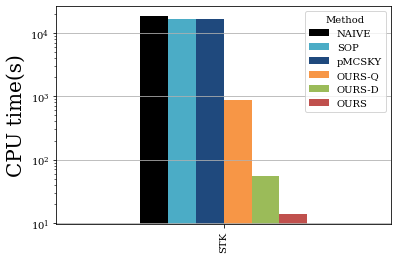

In [7]:
ax = graphdf.plot(kind='bar',color=algo_color.values())
# plt figure settings
ax.grid(b=True,which="major",axis='y')
ax.set_yscale("log")
ax.set_xlabel("")
ax.set_ylabel('CPU time(s)', fontsize=fontsize_xLabel)

# TODO: Put pattern in the bar graph

# remove ticks
ax.tick_params(axis ='both', which ='both', length = 0)
ax.tick_params(axis ='x', labelsize=fontsize_xLabel)
# rotate ticks
ax.tick_params(axis ='x', rotation = 0)
ax.get_legend().remove()
# color map for each bar

plt.savefig('asdf.pdf', bbox_inches='tight', format='pdf')
